**GROUPE :  
Anthony OUM   
Lauren RAKOTOSON**

A.  Base des données
La base de données « beer quality » comporte 1600 exemples décrits par 11 caractéristiques quantitatives. L’objectif est d’évaluer, sachant ces variables, la qualité d’une bière, évaluée de 1 (sans commentaire !) à 10 (particulièrement excellente).

Charger la base et la séparer en deux : la matrice X des observations et le vecteur y des labels.

Diviser la base de données en deux sous-ensembles d’apprentissage et de test (70/30). Analyser rapidement les variables prédictives X_train et la variable à prédire y_train (quality).



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = "/content/beer_quality.xlsx"
beer_data = pd.read_excel(file_path)
X = beer_data.drop('quality', axis=1)
y = beer_data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

B. Classification binaire
1)	Créer une nouvelle variable quantitative ybin à deux modalités :
-	0 : mauvaise qualité : y < médiane  
-	1 : bonne qualité : y  >= médiane  
en fonction de la médiane m de la variable y. Dans cette partie, c’est ybin qu’on cherchera à prédire.


In [ ]:
import numpy as np

median_y_train = np.median(y_train)

print("la valeur median de y est : ",median_y_train)
ybin_train = np.where(y_train < median_y_train, 0, 1)
ybin_test = np.where(y_test < median_y_train, 0, 1)

print("Aperçu de ybin_train:")
print(ybin_train[:10])

print("Aperçu de ybin_test:")
print(ybin_test[:10])

la valeur median de y est :  6.0
Aperçu de ybin_train:
[1 0 0 1 0 1 1 0 0 0]
Aperçu de ybin_test:
[1 0 1 0 1 0 0 0 0 1]


2)	Optimiser rapidement un arbre de décision pour réaliser la classification en faisant une recherche aléatoire (random search).

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

model_decision_tree = DecisionTreeClassifier()

param_dist = {
    'criterion': ['gini', 'entropy','log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(1, 50),
}

random_search = RandomizedSearchCV(model_decision_tree, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)

random_search.fit(X_train, ybin_train)
print("Meilleurs hyperparamètres trouvés:")
print(random_search.best_params_)
print("Meilleure précision obtenue:")
print(random_search.best_score_)


Meilleurs hyperparamètres trouvés:
{'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 25, 'min_samples_split': 28, 'splitter': 'best'}
Meilleure précision obtenue:
0.7373038116591928


3)	Entraîner un ensemble d’arbres de décision « faibles » (peu, voire très peu profonds) à l’aide de l’algorithme AdaBoost . Analyser les performances en fonction des différents paramètres :

-	En particulier, tracer les courbes accuracy en fonction de n_estimators pour max_depth = 1, en apprentissage et en test.
-	Tracer la courbe accuracy en fonction de n_estimators pour max_depth = 5, en apprentissage et en test.
-	Peut-on mesurer l’importance d’une caractéristique dans la décision AdaBoost ? Expliquez. Afficher les variables par ordre d’importance.
-	Conclure sur le biais et la variance de l’algorithme.


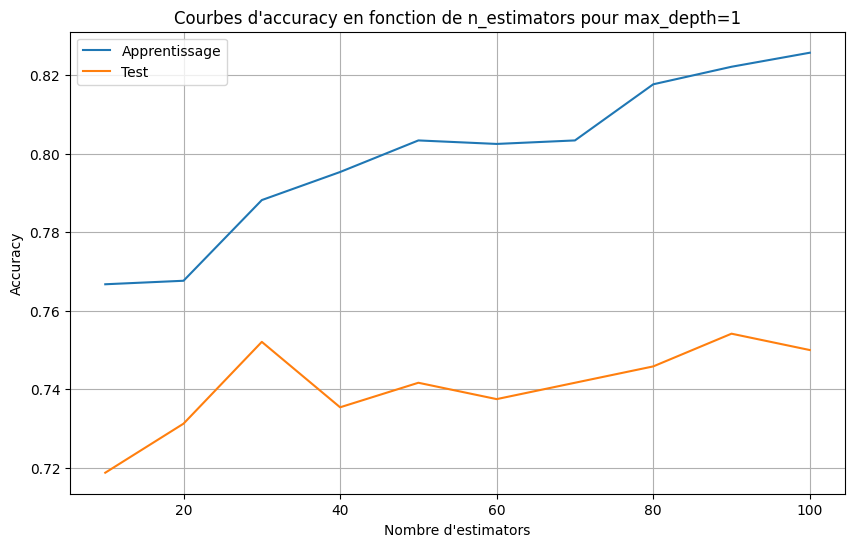

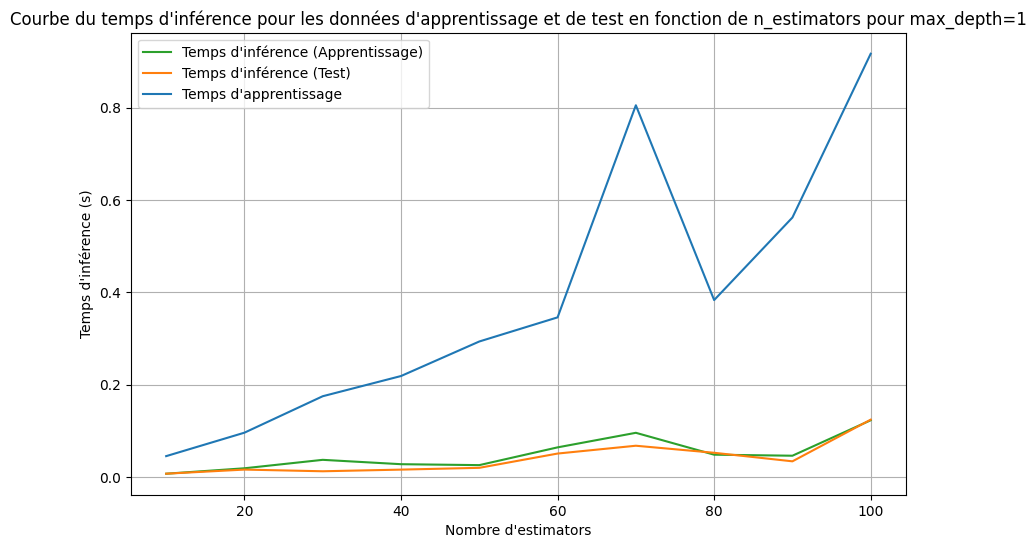

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

# Définir différentes valeurs de n_estimators à tester
n_estimators_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Initialiser des listes pour stocker les performances en apprentissage et en test
train_accuracies = []
test_accuracies = []
inference_times_train = []
inference_times_test = []
Temps_apprentissage = []

# Entraîner des ensembles AdaBoost avec différents nombres d'estimateurs (n_estimators)
for n_estimators in n_estimators_values:
    # Créer un classifieur AdaBoost avec des arbres de décision faibles (max_depth=1)
    ada_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=n_estimators, random_state=42)

    # Entraîner le modèle sur les données d'apprentissage
    apprentissage_time_train = time.time()
    ada_classifier.fit(X_train, ybin_train)
    end_time_apprentissage = time.time()
    Temps_apprentissage_tf = end_time_apprentissage - apprentissage_time_train

    # Prédire sur les données de apprentissage et de test
    start_time_train = time.time()
    y_train_pred = ada_classifier.predict(X_train)
    end_time_train = time.time()
    inference_time_train = end_time_train - start_time_train

    start_time_test = time.time()
    y_test_pred = ada_classifier.predict(X_test)
    end_time_test = time.time()
    inference_time_test = end_time_test - start_time_test

    # Calculer l'accuracy et l'ajouter aux listes
    train_accuracy = accuracy_score(ybin_train, y_train_pred)
    test_accuracy = accuracy_score(ybin_test, y_test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    Temps_apprentissage.append(Temps_apprentissage_tf)
    inference_times_train.append(inference_time_train)
    inference_times_test.append(inference_time_test)

# Tracer les courbes d'accuracy et de temps d'inférence en fonction de n_estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_accuracies, label='Apprentissage')
plt.plot(n_estimators_values, test_accuracies, label='Test')
plt.title('Courbes d\'accuracy en fonction de n_estimators pour max_depth=1')
plt.xlabel('Nombre d\'estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Tracer la courbe du temps d'inférence pour les données d'apprentissage et de test
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_estimators_values, inference_times_train, label='Temps d\'inférence (Apprentissage)', color='tab:green')
ax.plot(n_estimators_values, inference_times_test, label='Temps d\'inférence (Test)', color='tab:orange')
ax.plot(n_estimators_values, Temps_apprentissage, label='Temps d\'apprentissage', color='tab:blue')
ax.set_xlabel('Nombre d\'estimators')
ax.set_ylabel('Temps d\'inférence (s)')
ax.legend()
plt.title('Courbe du temps d\'inférence pour les données d\'apprentissage et de test en fonction de n_estimators pour max_depth=1')
plt.grid()
plt.show()

In [ ]:
# Create lists to store results
n_estimators_list = []
temps_apprentissage_list_ada_1 = []
temps_inference_train_list_ada_1 = []
temps_inference_test_list_ada_1 = []
train_accuracy_list_ada_1 = []
test_accuracy_list_ada_1 = []

# Populate the lists
for i, n_estimators in enumerate(n_estimators_values):
    n_estimators_list.append(n_estimators)
    temps_apprentissage_list_ada_1.append(Temps_apprentissage[i])
    temps_inference_train_list_ada_1.append(inference_times_train[i])
    temps_inference_test_list_ada_1.append(inference_times_test[i])
    train_accuracy_list_ada_1.append(train_accuracies[i])
    test_accuracy_list_ada_1.append(test_accuracies[i])

# Print the results as lists
print("n_estimators:", n_estimators_list)
print("Temps_apprentissage:", temps_apprentissage_list_ada_1)
print("Temps_inference_train:", temps_inference_train_list_ada_1)
print("Temps_inference_test:", temps_inference_test_list_ada_1)
print("Train_Accuracy:", train_accuracy_list_ada_1)
print("Test_Accuracy:", test_accuracy_list_ada_1)


n_estimators: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Temps_apprentissage: [0.04541349411010742, 0.09624576568603516, 0.17520713806152344, 0.2189793586730957, 0.2938053607940674, 0.34607505798339844, 0.8056137561798096, 0.3835408687591553, 0.5624294281005859, 0.9172999858856201]
Temps_inference_train: [0.007308244705200195, 0.019095659255981445, 0.03739500045776367, 0.027945756912231445, 0.025925159454345703, 0.06440496444702148, 0.0959627628326416, 0.048543453216552734, 0.046320199966430664, 0.12315487861633301]
Temps_inference_test: [0.007376432418823242, 0.016257047653198242, 0.01262044906616211, 0.016198158264160156, 0.020085811614990234, 0.051003456115722656, 0.06794404983520508, 0.052674055099487305, 0.034174442291259766, 0.12448310852050781]
Train_Accuracy: [0.7667560321715817, 0.7676496872207328, 0.7882037533512064, 0.7953529937444147, 0.803395889186774, 0.8025022341376229, 0.803395889186774, 0.8176943699731903, 0.8221626452189454, 0.8257372654155496]
Test_Accuracy: [0.71875,

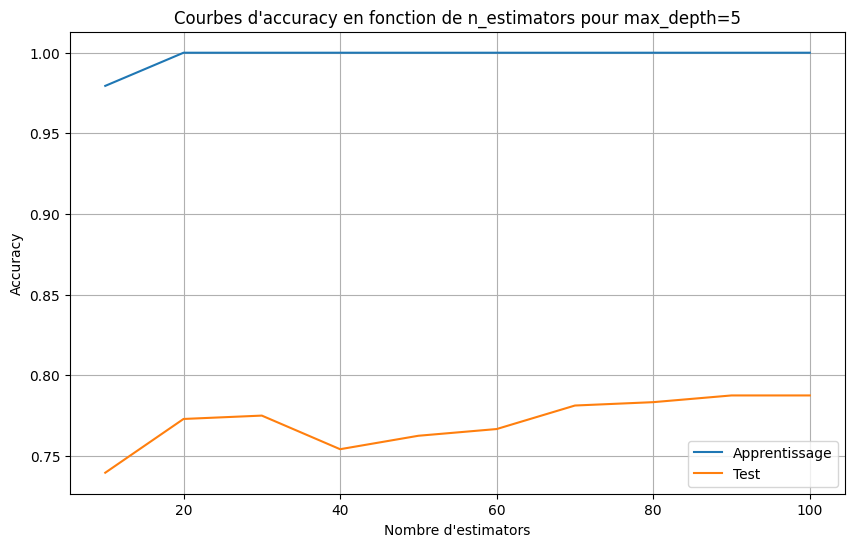

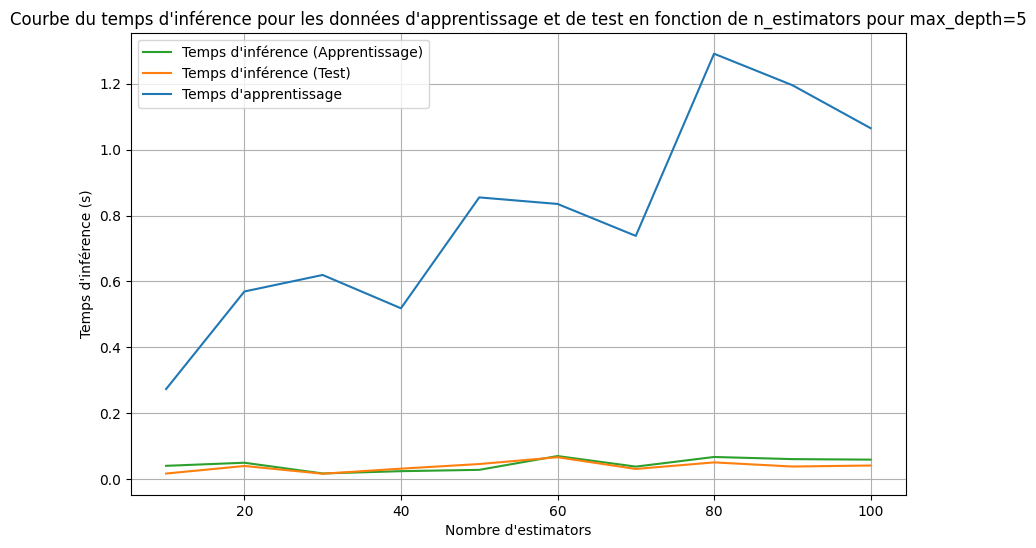

In [ ]:
# Initialiser des listes pour stocker les performances en apprentissage et en test
train_accuracies = []
test_accuracies = []
inference_times_train = []
inference_times_test = []
Temps_apprentissage = []


for n_estimators in n_estimators_values:
    # Créer un classifieur AdaBoost avec des arbres de décision faibles (max_depth=5)
    ada_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=n_estimators, random_state=42)

    # Entraîner le modèle sur les données d'apprentissage
    apprentissage_time_train = time.time()
    ada_classifier.fit(X_train, ybin_train)
    end_time_apprentissage = time.time()
    Temps_apprentissage_tf = end_time_apprentissage - apprentissage_time_train

    # Prédire sur les données d'apprentissage et de test
    start_time_train = time.time()
    y_train_pred = ada_classifier.predict(X_train)
    end_time_train = time.time()
    inference_time_train = end_time_train - start_time_train

    start_time_test = time.time()
    y_test_pred = ada_classifier.predict(X_test)
    end_time_test = time.time()
    inference_time_test = end_time_test - start_time_test

    # Calculer l'accuracy et l'ajouter aux listes
    train_accuracy = accuracy_score(ybin_train, y_train_pred)
    test_accuracy = accuracy_score(ybin_test, y_test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    Temps_apprentissage.append(Temps_apprentissage_tf)
    inference_times_train.append(inference_time_train)
    inference_times_test.append(inference_time_test)

# Tracer les courbes d'accuracy et de temps d'inférence en fonction de n_estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_accuracies, label='Apprentissage')
plt.plot(n_estimators_values, test_accuracies, label='Test')
plt.title('Courbes d\'accuracy en fonction de n_estimators pour max_depth=5')
plt.xlabel('Nombre d\'estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Tracer la courbe du temps d'inférence pour les données d'apprentissage et de test
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_estimators_values, inference_times_train, label='Temps d\'inférence (Apprentissage)', color='tab:green')
ax.plot(n_estimators_values, inference_times_test, label='Temps d\'inférence (Test)', color='tab:orange')
ax.plot(n_estimators_values, Temps_apprentissage, label='Temps d\'apprentissage', color='tab:blue')
ax.set_xlabel('Nombre d\'estimators')
ax.set_ylabel('Temps d\'inférence (s)')
ax.legend()
plt.title('Courbe du temps d\'inférence pour les données d\'apprentissage et de test en fonction de n_estimators pour max_depth=5')
plt.grid()
plt.show()


In [ ]:
# Create lists to store results
n_estimators_list = []
temps_apprentissage_list_ada_5 = []
temps_inference_train_list_ada_5 = []
temps_inference_test_list_ada_5 = []
train_accuracy_list_ada_5 = []
test_accuracy_list_ada_5 = []

# Populate the lists
for i, n_estimators in enumerate(n_estimators_values):
    n_estimators_list.append(n_estimators)
    temps_apprentissage_list_ada_5.append(Temps_apprentissage[i])
    temps_inference_train_list_ada_5.append(inference_times_train[i])
    temps_inference_test_list_ada_5.append(inference_times_test[i])
    train_accuracy_list_ada_5.append(train_accuracies[i])
    test_accuracy_list_ada_5.append(test_accuracies[i])

# Print the results as lists
print("n_estimators:", n_estimators_list)
print("Temps_apprentissage:", temps_apprentissage_list_ada_5)
print("Temps_inference_train:", temps_inference_train_list_ada_5)
print("Temps_inference_test:", temps_inference_test_list_ada_5)
print("Train_Accuracy:", train_accuracy_list_ada_5)
print("Test_Accuracy:", test_accuracy_list_ada_5)


n_estimators: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Temps_apprentissage: [0.2728538513183594, 0.5692527294158936, 0.6194157600402832, 0.5182344913482666, 0.8550333976745605, 0.8351702690124512, 0.7381141185760498, 1.2914834022521973, 1.195908546447754, 1.065234899520874]
Temps_inference_train: [0.039673805236816406, 0.04907870292663574, 0.016485214233398438, 0.023432493209838867, 0.027468442916870117, 0.06935715675354004, 0.03726339340209961, 0.06657767295837402, 0.06008410453796387, 0.05846762657165527]
Temps_inference_test: [0.01622748374938965, 0.03918099403381348, 0.015697002410888672, 0.031101465225219727, 0.045089006423950195, 0.06579875946044922, 0.030194759368896484, 0.050107479095458984, 0.03756880760192871, 0.040632009506225586]
Train_Accuracy: [0.9794459338695264, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test_Accuracy: [0.7395833333333334, 0.7729166666666667, 0.775, 0.7541666666666667, 0.7625, 0.7666666666666667, 0.78125, 0.7833333333333333, 0.7875, 0.7875]


-Choisir solution optimale :
Max_depth=5 et n_estimators=250

-	Peut-on mesurer l’importance d’une caractéristique dans la décision AdaBoost ? Expliquez. Afficher les variables par ordre d’importance.

on peut mesurer l'importance d'une caractéristique en examinant la contribution de chaque caractéristique dans le processus de prise de décision.L'importance des caractéristiques dans AdaBoost est déterminée en fonction de la fréquence à laquelle une caractéristique est utilisée pour créer les arbres de décision faibles pendant l'entraînement du modèle.

In [ ]:
# Créer un classifieur AdaBoost avec des arbres de décision faibles (max_depth=5)
ada_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=150, random_state=42)

# Entraîner le modèle sur les données d'apprentissage
ada_classifier.fit(X_train, ybin_train)

# Obtenir les noms des caractéristiques
feature_names = X_train.columns

# Afficher l'importance des caractéristiques
feature_importances = ada_classifier.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Afficher les variables par ordre d'importance
print("Variables par ordre d'importance :")
for index in sorted_indices:
    print(f"{feature_names[index]}: {feature_importances[index]:.4f}")


Variables par ordre d'importance :
density: 0.1193
chlorides: 0.1173
pH: 0.0985
total sulfur dioxide: 0.0938
volatile acidity: 0.0921
sulphates: 0.0920
citric acid: 0.0884
fixed acidity: 0.0804
residual sugar: 0.0776
free sulfur dioxide: 0.0765
alcohol: 0.0641


**Conclusion**  

Dans l'algorithme AdaBoost, augmenter la profondeur des arbres réduit potentiellement le biais en améliorant la capacité d'ajustement à des modèles complexes à chaque itération.De même, l'augmentation du nombre d'estimateurs réduit la variance, mais un nombre excessif peut ne pas apporter d'amélioration significative. L'objectif est de trouver un équilibre optimal entre la quantité et la profondeur des arbres pour obtenir un modèle bien équilibré en termes de biais et de variance. A noté que dans notre cas la quantité et la profondeur des arbres n'influe pas significativement sur le temps d'inference

C.  Classification multiclasse  
1)	Créer une nouvelle variable quantitative ymulti discrète à 3 modalités : qualité basse (0), moyenne (1) ou élevée (2).


In [ ]:
import numpy as np

ymulti_train = np.zeros_like(y_train, dtype=int)

ymulti_train[y_train < 5] = 0  # Qualité basse
ymulti_train[(y_train >= 5) & (y_train < 6)] = 1  # Qualité moyenne
ymulti_train[y_train >= 6] = 2  #  élevée

In [ ]:
ymulti_test = np.zeros_like(y_test, dtype=int)

ymulti_test[y_test < 5] = 0  # Qualité basse
ymulti_test[(y_test >= 5) & (y_test < 6)] = 1  # Qualité moyenne
ymulti_test[y_test >= 6] = 2  #  élevée

2)	Déterminer les effectifs des différentes classes. Si nécessaire, équilibrer les données d’apprentissage par sous-échantillonnage ou augmentation de données (SMOTE). Dans la suite, on présentera les résultats obtenus avec et sans équilibrage.

In [ ]:
from imblearn.over_sampling import SMOTE

# Step 1: Determine Class Frequencies
print("Results on Original Dataset:")
counts = np.bincount(ymulti_train)
for i, count in enumerate(counts):
    print(f"Nombre de {i}: {count}")

# Step 2: Address Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, ymulti_train)

print("\nResults on Balanced Dataset (with SMOTE):")
counts_resampled = np.bincount(y_train_resampled)
for i, count in enumerate(counts_resampled):
    print(f"Nombre de {i}: {count}")

Results on Original Dataset:
Nombre de 0: 45
Nombre de 1: 486
Nombre de 2: 588

Results on Balanced Dataset (with SMOTE):
Nombre de 0: 588
Nombre de 1: 588
Nombre de 2: 588


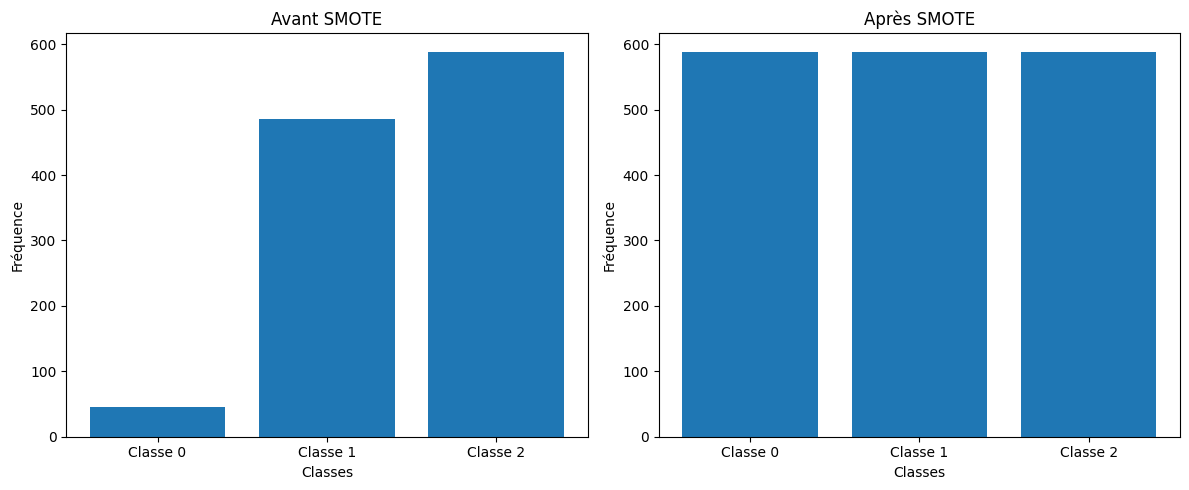

In [ ]:
# Plotting the histogram
labels = [f"Classe {i}" for i in range(len(counts))]
labels_resampled = [f"Classe {i}" for i in range(len(counts_resampled))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(labels, counts)
ax1.set_title('Avant SMOTE')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Fréquence')

ax2.bar(labels_resampled, counts_resampled)
ax2.set_title('Après SMOTE')
ax2.set_xlabel('Classes')
ax2.set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

# Step 1: Determine Class Frequencies
print("Results on Original Dataset:")
counts = np.bincount(ymulti_test)
for i, count in enumerate(counts):
    print(f"Nombre de {i}: {count}")

# Step 2: Address Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, ymulti_test)

print("\nResults on Balanced Dataset (with SMOTE):")
counts_resampled = np.bincount(y_test_resampled)
for i, count in enumerate(counts_resampled):
    print(f"Nombre de {i}: {count}")

Results on Original Dataset:
Nombre de 0: 18
Nombre de 1: 195
Nombre de 2: 267

Results on Balanced Dataset (with SMOTE):
Nombre de 0: 267
Nombre de 1: 267
Nombre de 2: 267


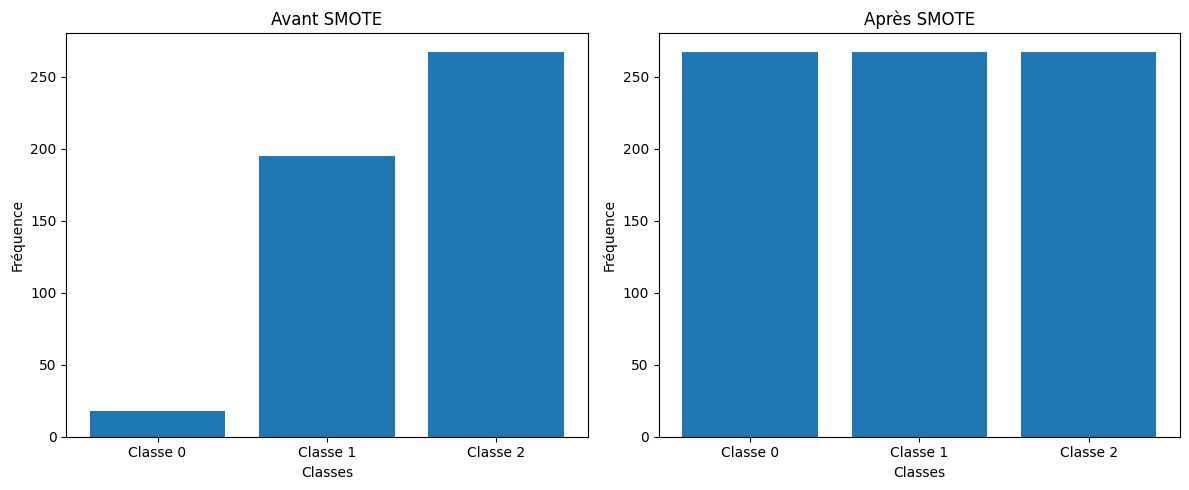

In [ ]:
# Plotting the histogram
labels = [f"Classe {i}" for i in range(len(counts))]
labels_resampled = [f"Classe {i}" for i in range(len(counts_resampled))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(labels, counts)
ax1.set_title('Avant SMOTE')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Fréquence')

ax2.bar(labels_resampled, counts_resampled)
ax2.set_title('Après SMOTE')
ax2.set_xlabel('Classes')
ax2.set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

# Partie 1

3)	Entraîner un réseau de neurones à une couche cachée pour effectuer cette tâche de classification, avec early stopping sur la base de validation. L’optimiser rapidement en prenant soin d’éviter l’over-fitting. Etudier les matrices de confusion des réseaux optimaux dans le cas des données déséquilibrées puis, équilibrées. Conclure.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Define and train the neural network on the original dataset
clf_imbalanced = MLPClassifier(hidden_layer_sizes=(32,), max_iter=500, random_state=42, early_stopping=True, validation_fraction=0.2)
clf_imbalanced.fit(X_train, ymulti_train)

# Predictions on the original test set
y_pred_imbalanced = clf_imbalanced.predict(X_test)

# Confusion matrix and classification report for the original dataset
conf_matrix_imbalanced = confusion_matrix(ymulti_test, y_pred_imbalanced)

print("Confusion Matrix for Original Dataset:")
print(conf_matrix_imbalanced)
# Calculate accuracy for the original dataset
accuracy_imbalanced = accuracy_score(ymulti_test, y_pred_imbalanced)
print(f"Accuracy for Original Dataset: {accuracy_imbalanced:.4f}")
f1_score_imbalanced = f1_score(ymulti_test, y_pred_imbalanced, average='weighted')
print(f"F1-Score for Original Dataset: {f1_score_imbalanced:.4f}")

Confusion Matrix for Original Dataset:
[[  0   4  14]
 [  0  98  97]
 [  0  67 200]]
Accuracy for Original Dataset: 0.6208
F1-Score for Original Dataset: 0.6037


Le modèle a du mal à classifier correctement la classe "Qualité basse" (0) Il prédit principalement les classes  "Qualité moyenne" (1) et "Qualité élevée" (2) etant donnée que les classes (2) et (3) sont majoritaire dans la base de donnée déséquilibrées.le F1-score de 58.71% qui est inferieur a l'accuracy 62,71%, cela souligne une performance limitée du modèle face à des classes déséquilibrées.

In [ ]:
# Define and train the neural network on the balanced dataset (with SMOTE)
clf_balanced = MLPClassifier(hidden_layer_sizes=(32,), max_iter=500, random_state=42, early_stopping=True, validation_fraction=0.2)
clf_balanced.fit(X_train_resampled, y_train_resampled)

# Predictions on the balanced test set
y_pred_balanced = clf_balanced.predict(X_test)

# Confusion matrix and classification report for the balanced dataset
conf_matrix_balanced = confusion_matrix(ymulti_test, y_pred_balanced)

print("Confusion Matrix for Balanced Dataset (with SMOTE):")
print(conf_matrix_balanced)
# Calculate accuracy for the balanced dataset (with SMOTE)
accuracy_balanced = accuracy_score(ymulti_test, y_pred_balanced)
print(f"Accuracy for Balanced Dataset (with SMOTE): {accuracy_balanced:.4f}")
f1_score_balanced = f1_score(ymulti_test, y_pred_balanced, average='weighted')
print(f"F1-Score for Balanced Dataset (with SMOTE): {f1_score_balanced:.4f}")

Confusion Matrix for Balanced Dataset (with SMOTE):
[[  9   4   5]
 [ 36 105  54]
 [ 21  68 178]]
Accuracy for Balanced Dataset (with SMOTE): 0.6083
F1-Score for Balanced Dataset (with SMOTE): 0.6303


L'équilibrage des données avec SMOTE semble avoir aidé à réduire les disparités entre les classes
Le modèle montre une amélioration des performances pour la classe "Qualité basse" (0) par rapport au jeu de données original. Bien que l'accuracy ait légèrement diminué à 60.83%, la mesure du F1-score s'élève à 63.03%, soulignant une performance globale plus équilibrée.

# Conclusion:
Le modèle entraîné sur le jeu de données équilibré avec SMOTE
montre une amélioration de la précision globale par rapport au modèle entraîné sur le jeu de données déséquilibré. Cette observation renforce l'idée que la technique SMOTE a contribué à renforcer la capacité du modèle à traiter efficacement les classes minoritaires, démontrant ainsi son utilité dans le contexte de la classification multiclasse.

4) Faire un bagging en utilisant comme classifieur de base le réseau de neurones.

-	Tracer la courbe accuracy en fonction de n_estimators, en apprentissage et en test.
-	Conclure sur le biais et la variance.

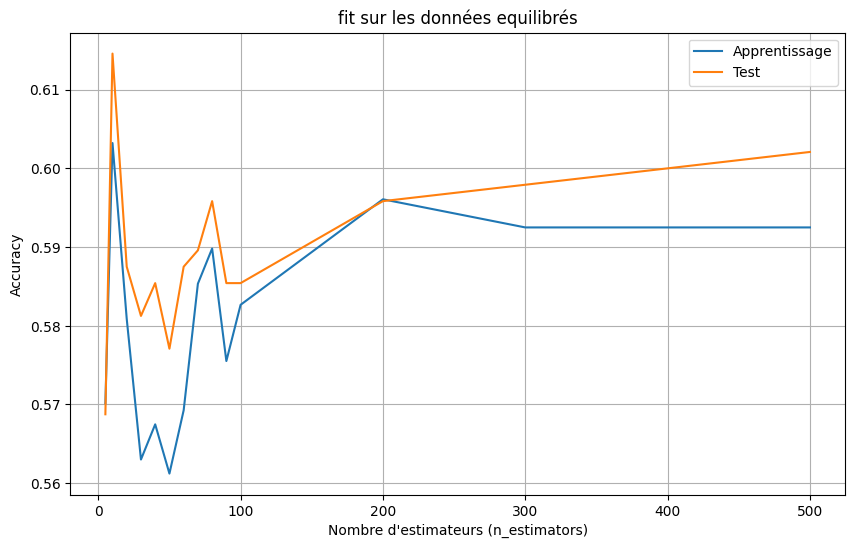

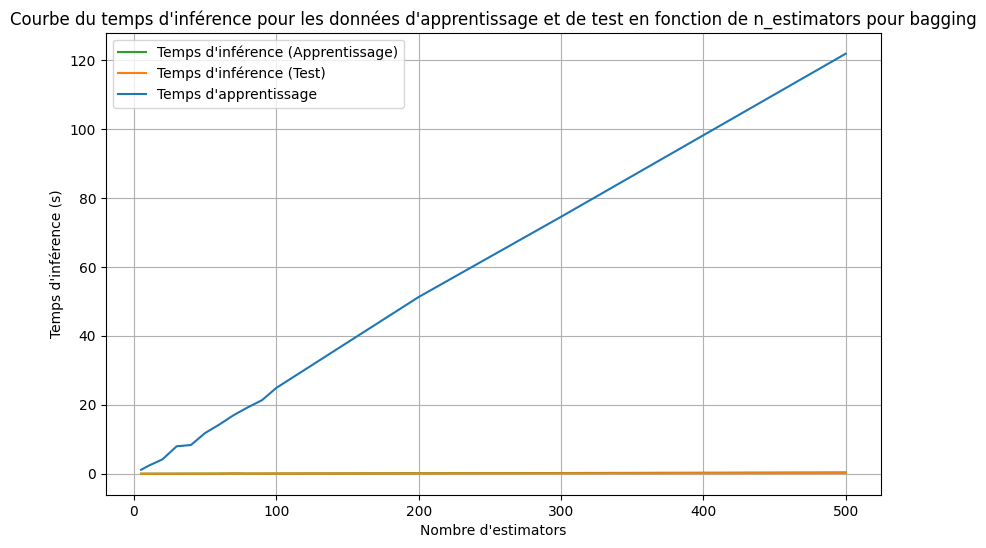

In [ ]:
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt

# Définir le classifieur de base (le réseau de neurones)
base_classifier = MLPClassifier(hidden_layer_sizes=(32,), max_iter=500, random_state=42, early_stopping=True, validation_fraction=0.2)

# Définir différentes valeurs de n_estimators
n_estimators_values = [5,10,20,30,40,50,60,70,80,90,100,200,300,500]

# Initialiser des listes pour stocker les résultats d'apprentissage et de validation
train_accuracies = []
test_accuracies = []
inference_times_train = []  # Initialize the list
inference_times_test = []   # Initialize the list
Temps_apprentissage = []

# Entraîner le modèle avec différentes valeurs de n_estimators
for n_estimators in n_estimators_values:
    bagging_classifier = BaggingClassifier(base_classifier, n_estimators=n_estimators, random_state=42)
    apprentissage_time_train = time.time()
    bagging_classifier.fit(X_train_resampled, y_train_resampled)
    end_time_apprentissage = time.time()
    Temps_apprentissage_tf = end_time_apprentissage - apprentissage_time_train
    Temps_apprentissage.append(Temps_apprentissage_tf)

    # Prédiction sur l'ensemble d'apprentissage
    start_time_train = time.time()
    y_train_pred = bagging_classifier.predict(X_train)
    end_time_train = time.time()
    inference_time_train = end_time_train - start_time_train
    inference_times_train.append(inference_time_train)  # Append the inference time to the list

    train_accuracy = accuracy_score(ymulti_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Prédiction sur l'ensemble de test
    start_time_test = time.time()
    y_test_pred = bagging_classifier.predict(X_test)
    end_time_test = time.time()
    inference_time_test = end_time_test - start_time_test
    inference_times_test.append(inference_time_test)   # Append the inference time to the list

    test_accuracy = accuracy_score(ymulti_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Tracer la courbe accuracy en fonction de n_estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_accuracies, label='Apprentissage')
plt.plot(n_estimators_values, test_accuracies, label='Test')
plt.xlabel('Nombre d\'estimateurs (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('fit sur les données equilibrés')
plt.grid()
plt.show()

# Tracer la courbe du temps d'inférence pour les données d'apprentissage et de test
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_estimators_values, inference_times_train, label='Temps d\'inférence (Apprentissage)', color='tab:green')
ax.plot(n_estimators_values, inference_times_test, label='Temps d\'inférence (Test)', color='tab:orange')
ax.plot(n_estimators_values, Temps_apprentissage, label='Temps d\'apprentissage', color='tab:blue')
ax.set_xlabel('Nombre d\'estimators')
ax.set_ylabel('Temps d\'inférence (s)')
ax.legend()
plt.title('Courbe du temps d\'inférence pour les données d\'apprentissage et de test en fonction de n_estimators pour bagging')
plt.grid()
plt.show()

In [ ]:
# Create lists to store results
n_estimators_list_bagging_equilibre = []
temps_apprentissage_list_bagging_equilibre = []
temps_inference_train_list_bagging_equilibre = []
temps_inference_test_list_bagging_equilibre = []
train_accuracy_list_bagging_equilibre = []
test_accuracy_list_bagging_equilibre = []

# Populate the lists
for i, n_estimators in enumerate(n_estimators_values):
    n_estimators_list_bagging_equilibre.append(n_estimators)
    temps_apprentissage_list_bagging_equilibre.append(Temps_apprentissage[i])
    temps_inference_train_list_bagging_equilibre.append(inference_times_train[i])
    temps_inference_test_list_bagging_equilibre.append(inference_times_test[i])
    train_accuracy_list_bagging_equilibre.append(train_accuracies[i])
    test_accuracy_list_bagging_equilibre.append(test_accuracies[i])

# Print the results as lists
print("n_estimators_bagging:", n_estimators_list_bagging_equilibre)
print("Temps_apprentissage_bagging:", temps_apprentissage_list_bagging_equilibre)
print("Temps_inference_train_bagging:", temps_inference_train_list_bagging_equilibre)
print("Temps_inference_test_bagging:", temps_inference_test_list_bagging_equilibre)
print("Train_Accuracy_bagging:", train_accuracy_list_bagging_equilibre)
print("Test_Accuracy_bagging:", test_accuracy_list_bagging_equilibre)


n_estimators_bagging: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 500]
Temps_apprentissage_bagging: [1.1556658744812012, 2.2701237201690674, 4.1688878536224365, 7.970554351806641, 8.326872110366821, 11.822336912155151, 14.290088653564453, 16.999541759490967, 19.277358531951904, 21.359710693359375, 24.90605068206787, 51.27847337722778, 74.54806232452393, 121.87323713302612]
Temps_inference_train_bagging: [0.006732940673828125, 0.009716987609863281, 0.016433238983154297, 0.02349543571472168, 0.044876813888549805, 0.04183673858642578, 0.045656681060791016, 0.10525083541870117, 0.05808854103088379, 0.06342935562133789, 0.07146263122558594, 0.1533365249633789, 0.21047258377075195, 0.3816487789154053]
Temps_inference_test_bagging: [0.005086660385131836, 0.007431745529174805, 0.010762214660644531, 0.014910697937011719, 0.018694639205932617, 0.023610591888427734, 0.02593827247619629, 0.06282258033752441, 0.03431200981140137, 0.04808688163757324, 0.061777591705322266, 0.0817601680755

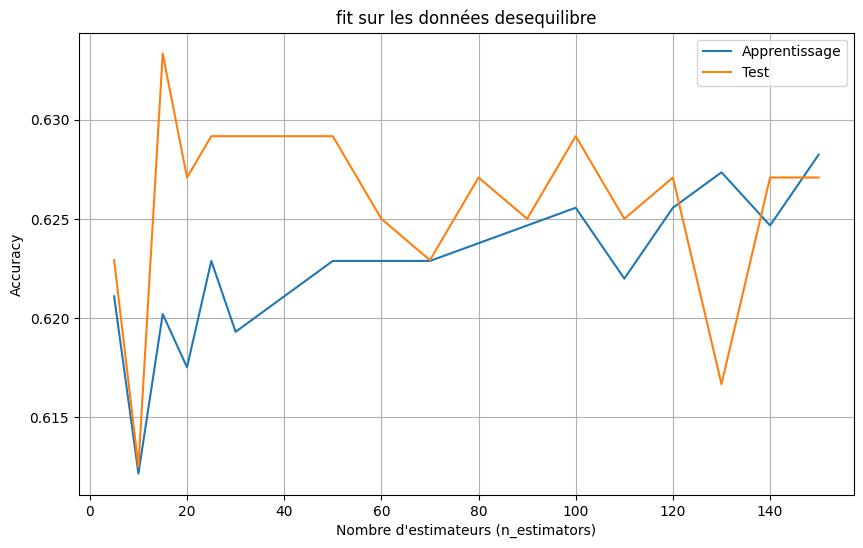

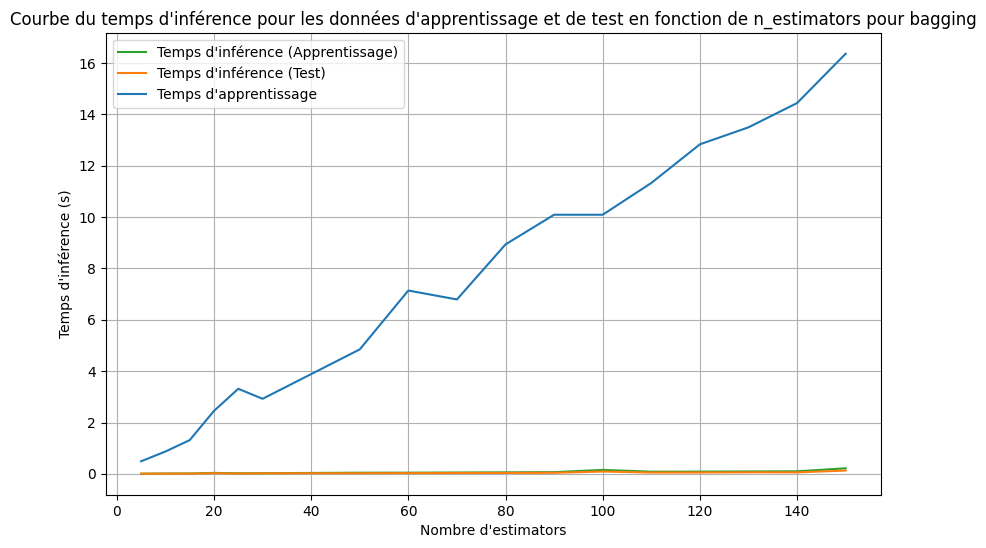

In [ ]:
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt

# Définir le classifieur de base (le réseau de neurones)
base_classifier = MLPClassifier(hidden_layer_sizes=(32,), max_iter=500, random_state=42, early_stopping=True, validation_fraction=0.2)

# Définir différentes valeurs de n_estimators
n_estimators_values = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,150]

# Initialiser des listes pour stocker les résultats d'apprentissage et de validation
train_accuracies = []
test_accuracies = []
inference_times_train = []  # Initialize the list
inference_times_test = []   # Initialize the list
Temps_apprentissage = []

# Entraîner le modèle avec différentes valeurs de n_estimators
for n_estimators in n_estimators_values:
    bagging_classifier = BaggingClassifier(base_classifier, n_estimators=n_estimators, random_state=42)

    apprentissage_time_train = time.time()
    bagging_classifier.fit(X_train, ymulti_train)
    end_time_apprentissage = time.time()
    Temps_apprentissage_tf = end_time_apprentissage - apprentissage_time_train
    Temps_apprentissage.append(Temps_apprentissage_tf)

    # Prédiction sur l'ensemble d'apprentissage
    start_time_train = time.time()
    y_train_pred = bagging_classifier.predict(X_train)
    end_time_train = time.time()
    inference_time_train = end_time_train - start_time_train
    inference_times_train.append(inference_time_train)  # Append the inference time to the list

    train_accuracy = accuracy_score(ymulti_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Prédiction sur l'ensemble de test
    start_time_test = time.time()
    y_test_pred = bagging_classifier.predict(X_test)
    end_time_test = time.time()
    inference_time_test = end_time_test - start_time_test
    inference_times_test.append(inference_time_test)   # Append the inference time to the list

    test_accuracy = accuracy_score(ymulti_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Tracer la courbe accuracy en fonction de n_estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_accuracies, label='Apprentissage')
plt.plot(n_estimators_values, test_accuracies, label='Test')
plt.xlabel('Nombre d\'estimateurs (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('fit sur les données desequilibre')
plt.grid()
plt.show()

# Tracer la courbe du temps d'inférence pour les données d'apprentissage et de test
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_estimators_values, inference_times_train, label='Temps d\'inférence (Apprentissage)', color='tab:green')
ax.plot(n_estimators_values, inference_times_test, label='Temps d\'inférence (Test)', color='tab:orange')
ax.plot(n_estimators_values, Temps_apprentissage, label='Temps d\'apprentissage', color='tab:blue')
ax.set_xlabel('Nombre d\'estimators')
ax.set_ylabel('Temps d\'inférence (s)')
ax.legend()
plt.title('Courbe du temps d\'inférence pour les données d\'apprentissage et de test en fonction de n_estimators pour bagging')
plt.grid()
plt.show()

In [ ]:
# Create lists to store results
n_estimators_list_desequilibrees = []
temps_apprentissage_list_bagging_desequilibrees = []
temps_inference_train_list_bagging_desequilibrees = []
temps_inference_test_list_bagging_desequilibrees = []
train_accuracy_list_bagging_desequilibrees = []
test_accuracy_list_bagging_desequilibrees = []

# Populate the lists
for i, n_estimators in enumerate(n_estimators_values):
    n_estimators_list_desequilibrees.append(n_estimators)
    temps_apprentissage_list_bagging_desequilibrees.append(Temps_apprentissage[i])
    temps_inference_train_list_bagging_desequilibrees.append(inference_times_train[i])
    temps_inference_test_list_bagging_desequilibrees.append(inference_times_test[i])
    train_accuracy_list_bagging_desequilibrees.append(train_accuracies[i])
    test_accuracy_list_bagging_desequilibrees.append(test_accuracies[i])

# Print the results as lists
print("n_estimators_bagging:", n_estimators_list_desequilibrees)
print("Temps_apprentissage_bagging:", temps_apprentissage_list_bagging_desequilibrees)
print("Temps_inference_train_bagging:", temps_inference_train_list_bagging_desequilibrees)
print("Temps_inference_test_bagging:", temps_inference_test_list_bagging_desequilibrees)
print("Train_Accuracy_bagging:", train_accuracy_list_bagging_desequilibrees)
print("Test_Accuracy_bagging:", test_accuracy_list_bagging_desequilibrees)


n_estimators_bagging: [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
Temps_apprentissage_bagging: [0.48950934410095215, 0.86883544921875, 1.312800407409668, 2.4524683952331543, 3.3134500980377197, 2.9231252670288086, 4.848395347595215, 7.1410746574401855, 6.793350458145142, 8.938622236251831, 10.094387531280518, 10.093669891357422, 11.33181357383728, 12.836685180664062, 13.498570442199707, 14.443872213363647, 16.36655306816101]
Temps_inference_train_bagging: [0.005747556686401367, 0.013075113296508789, 0.012548446655273438, 0.036580801010131836, 0.02005743980407715, 0.0252993106842041, 0.04383540153503418, 0.044595956802368164, 0.05129718780517578, 0.057776451110839844, 0.06438446044921875, 0.15341615676879883, 0.0835726261138916, 0.08668994903564453, 0.09248137474060059, 0.0980062484741211, 0.21560001373291016]
Temps_inference_test_bagging: [0.0046122074127197266, 0.006630420684814453, 0.008763313293457031, 0.024481534957885742, 0.012753486633300781, 0.02138

On peut voir que la variance du modèle diminue avec l'augmentation du nombre d'estimateurs. Cela est dû au fait que les sous-échantillons aléatoires utilisés pour entraîner les différents estimateurs sont moins susceptibles de capturer les mêmes fluctuations que l'ensemble d'apprentissage complet.

En revanche, le biais du modèle semble augmenter légèrement avec l'augmentation du nombre d'estimateurs. Cela est dû au fait que les différents estimateurs ont tendance à produire des prédictions similaires, ce qui peut entraîner une perte de précision.

En conclusion, le bagging peut être efficace pour réduire la variance d'un modèle, mais il peut également entraîner une augmentation du biais. Il est important de surveiller le biais du modèle pour éviter une baisse de précision.


# Partie 2

5)	Entraîner une forêt aléatoire :

-	Tracer la courbe accuracy en fonction de n_estimators pour max_depth = None, en apprentissage et en test.


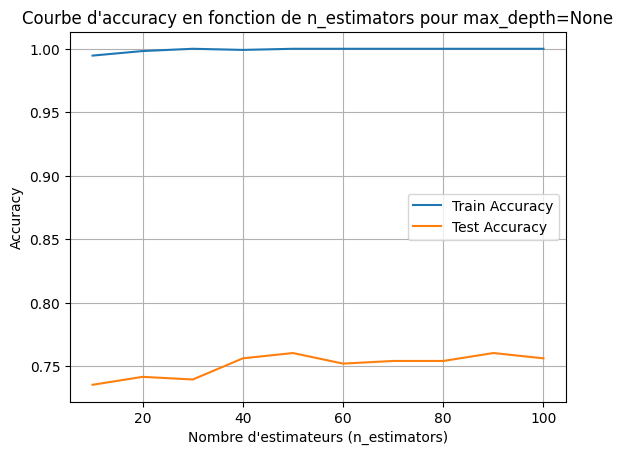

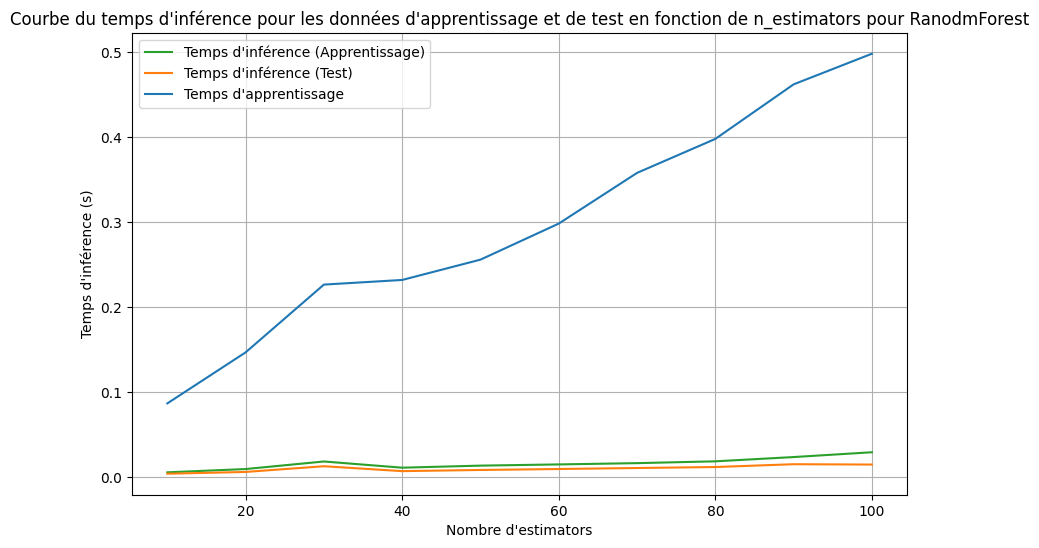

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Définir différentes valeurs de n_estimators à tester
n_estimators_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Initialiser des listes pour stocker les scores d'apprentissage et de test
train_scores = []
test_scores = []
inference_times_train = []  # Initialize the list
inference_times_test = []   # Initialize the list
Temps_apprentissage = []

# Boucle sur les valeurs de n_estimators
for n_estimators in n_estimators_values:
    # Créer le modèle de forêt aléatoire
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=None, random_state=42)

    # Entraîner le modèle sur les données d'entraînement
    apprentissage_time_train = time.time()
    rf_model.fit(X_train_resampled, y_train_resampled)
    end_time_apprentissage = time.time()
    Temps_apprentissage_tf = end_time_apprentissage - apprentissage_time_train
    Temps_apprentissage.append(Temps_apprentissage_tf)

    # Prédire les classes sur les ensembles d'entraînement et de test
    start_time_train = time.time()
    y_train_pred = rf_model.predict(X_train)
    end_time_train = time.time()
    inference_time_train = end_time_train - start_time_train
    inference_times_train.append(inference_time_train)  # Append the inference time to the list

    start_time_test = time.time()
    y_test_pred = rf_model.predict(X_test)
    end_time_test = time.time()
    inference_time_test = end_time_test - start_time_test
    inference_times_test.append(inference_time_test)   # Append the inference time to the list


    # Calculer les scores d'accuracy
    train_accuracy = accuracy_score(ymulti_train, y_train_pred)
    test_accuracy = accuracy_score(ymulti_test, y_test_pred)

    # Stocker les scores dans les listes
    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

# Tracer la courbe d'accuracy en fonction de n_estimators
plt.plot(n_estimators_values, train_scores, label='Train Accuracy')
plt.plot(n_estimators_values, test_scores, label='Test Accuracy')
plt.xlabel('Nombre d\'estimateurs (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Courbe d\'accuracy en fonction de n_estimators pour max_depth=None')
plt.legend()
plt.grid()
plt.show()

# Tracer la courbe du temps d'inférence pour les données d'apprentissage et de test
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_estimators_values, inference_times_train, label='Temps d\'inférence (Apprentissage)', color='tab:green')
ax.plot(n_estimators_values, inference_times_test, label='Temps d\'inférence (Test)', color='tab:orange')
ax.plot(n_estimators_values, Temps_apprentissage, label='Temps d\'apprentissage', color='tab:blue')
ax.set_xlabel('Nombre d\'estimators')
ax.set_ylabel('Temps d\'inférence (s)')
ax.legend()
plt.title('Courbe du temps d\'inférence pour les données d\'apprentissage et de test en fonction de n_estimators pour RanodmForest')
plt.grid()
plt.show()


In [ ]:
# Create lists to store results
n_estimators_list = []
temps_apprentissage_list_rf = []
temps_inference_train_list_rf = []
temps_inference_test_list_rf = []
train_accuracy_list_rf = []
test_accuracy_list_rf = []

# Populate the lists
for i, n_estimators in enumerate(n_estimators_values):
    n_estimators_list.append(n_estimators)
    temps_apprentissage_list_rf.append(Temps_apprentissage[i])
    temps_inference_train_list_rf.append(inference_times_train[i])
    temps_inference_test_list_rf.append(inference_times_test[i])
    train_accuracy_list_rf.append(train_scores[i])
    test_accuracy_list_rf.append(test_scores[i])

# Print the results as lists
print("n_estimators:", n_estimators_list)
print("Temps_apprentissage:", temps_apprentissage_list_rf)
print("Temps_inference_train:", temps_inference_train_list_rf)
print("Temps_inference_test:", temps_inference_test_list_rf)
print("Train_Accuracy:", train_accuracy_list_rf)
print("Test_Accuracy:", test_accuracy_list_rf)


n_estimators: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Temps_apprentissage: [0.0867166519165039, 0.14676260948181152, 0.22650790214538574, 0.23195409774780273, 0.2558567523956299, 0.2982907295227051, 0.3579401969909668, 0.3979153633117676, 0.46212005615234375, 0.4981682300567627]
Temps_inference_train: [0.005582094192504883, 0.009447336196899414, 0.01833176612854004, 0.011042356491088867, 0.01346898078918457, 0.014891386032104492, 0.01639246940612793, 0.018533706665039062, 0.023548364639282227, 0.02921295166015625]
Temps_inference_test: [0.0039408206939697266, 0.006027698516845703, 0.01274871826171875, 0.006982088088989258, 0.008346319198608398, 0.009478569030761719, 0.010663509368896484, 0.011821269989013672, 0.01513218879699707, 0.01473236083984375]
Train_Accuracy: [0.9946380697050938, 0.998212689901698, 1.0, 0.9991063449508489, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test_Accuracy: [0.7354166666666667, 0.7416666666666667, 0.7395833333333334, 0.75625, 0.7604166666666666, 0.7520833333333333, 0

-	Faire une recherche aléatoire (random search) pour optimiser les paramètres max_depth et n_estimators. Choisir les paramètres optimaux et donner les performances en apprentissage et en test. Comparer avec les résultats obtenus précédemment (matrice de confusion sur les données déséquilibrées et équilibrées).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Définir l'espace des hyperparamètres à explorer
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30]
}

# Créer le modèle RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Créer l'objet RandomizedSearchCV
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)

# Effectuer la recherche aléatoire sur les données d'entraînement
random_search.fit(X_train_resampled, y_train_resampled)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", random_search.best_params_)

# Prédire les classes sur l'ensemble d'entraînement
y_train_pred_random_search = random_search.predict(X_train)

# Prédire les classes sur l'ensemble de test
y_test_pred_random_search = random_search.predict(X_test)

# Afficher les performances en apprentissage
print("\nPerformances en apprentissage avec paramètres optimaux (Données equilibrées):")
print("Matrice de confusion :")
print(confusion_matrix(ymulti_train, y_train_pred_random_search))
print("\nAccuracy : {:.2f}%".format(accuracy_score(ymulti_train, y_train_pred_random_search) * 100))

# Afficher les performances en test
print("\nPerformances en test avec paramètres optimaux (Données equilibrées) :")
print("Matrice de confusion :")
print(confusion_matrix(ymulti_test, y_test_pred_random_search))
print("\nAccuracy : {:.2f}%".format(accuracy_score(ymulti_test, y_test_pred_random_search) * 100))


Meilleurs paramètres: {'n_estimators': 200, 'max_depth': 20}

Performances en apprentissage avec paramètres optimaux (Données equilibrées):
Matrice de confusion :
[[ 45   0   0]
 [  0 486   0]
 [  0   0 588]]

Accuracy : 100.00%

Performances en test avec paramètres optimaux (Données equilibrées) :
Matrice de confusion :
[[  4   7   7]
 [ 13 147  35]
 [  4  46 217]]

Accuracy : 76.67%


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Définir l'espace des hyperparamètres à explorer
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30]
}

# Créer le modèle RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Créer l'objet RandomizedSearchCV
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)

# Effectuer la recherche aléatoire sur les données d'entraînement
random_search.fit(X_train, ymulti_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", random_search.best_params_)

# Prédire les classes sur l'ensemble d'entraînement
y_train_pred_random_search = random_search.predict(X_train)

# Prédire les classes sur l'ensemble de test
y_test_pred_random_search = random_search.predict(X_test)

# Afficher les performances en apprentissage
print("\nPerformances en apprentissage avec paramètres optimaux  (Données desequilibrées) :")
print("Matrice de confusion :")
print(confusion_matrix(ymulti_train, y_train_pred_random_search))
print("\nAccuracy : {:.2f}%".format(accuracy_score(ymulti_train, y_train_pred_random_search) * 100))

# Afficher les performances en test
print("\nPerformances en test avec paramètres optimaux  (Données desequilibrées):")
print("Matrice de confusion :")
print(confusion_matrix(ymulti_test, y_test_pred_random_search))
print("\nAccuracy : {:.2f}%".format(accuracy_score(ymulti_test, y_test_pred_random_search) * 100))


Meilleurs paramètres: {'n_estimators': 100, 'max_depth': 10}

Performances en apprentissage avec paramètres optimaux  (Données desequilibrées) :
Matrice de confusion :
[[ 36   9   0]
 [  0 480   6]
 [  0  17 571]]

Accuracy : 97.14%

Performances en test avec paramètres optimaux  (Données desequilibrées):
Matrice de confusion :
[[  0  11   7]
 [  0 151  44]
 [  0  44 223]]

Accuracy : 77.92%


On obtient de meilleurs resultat globaux avec les données équilibrées que désequilibrées toutefois on perd aussi un peu en accuracy comme dans la partie C-1)

-	Afficher les variables par ordre d’importance. Retrouve-t-on les mêmes variables qu’en B.3 ?

In [ ]:
# Accéder aux importances des variables
importances = random_search.best_estimator_.feature_importances_

# Créer un DataFrame pour afficher les résultats
importances_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': importances})

# Trier le DataFrame par ordre d'importance décroissante
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Afficher le DataFrame des importances
print("Variables par ordre d'importance :")
print(importances_df)


Variables par ordre d'importance :
                Variable  Importance
10               alcohol    0.210353
9              sulphates    0.119526
1       volatile acidity    0.109760
6   total sulfur dioxide    0.104362
7                density    0.089158
4              chlorides    0.074643
0          fixed acidity    0.068415
8                     pH    0.058281
2            citric acid    0.058254
3         residual sugar    0.056842
5    free sulfur dioxide    0.050406


On ne trouve pas les mêmes variables qu'en B3

Les différences dans l'importance des caractéristiques entre le modèle AdaBoost (B3) et le modèle Random Forest (C5) sont dues à la manière dont ces algorithmes évaluent le rôle de chaque aspect.

Dans AdaBoost (B3), qui utilise des règles de décision modestes, certaines caractéristiques sont privilégiées car elles contribuent progressivement à améliorer les performances du modèle.

D'un autre côté, dans le modèle Random Forest (C5), qui combine plusieurs règles de décision, l'influence de chaque caractéristique est équilibrée, pouvant ainsi mettre en avant différentes caractéristiques.

On peut tout de meme remarquer que dans le top 5 du modèle Random Forest et Adaboost 3 Variables sont identiques volatile acidity, total sulfur dioxide et ph

En résumé, ces variations dans l'importance des caractéristiques reflètent les divergences dans la façon dont les modèles abordent l'évaluation des caractéristiques, tout en étant influencées par la nature spécifique de chaque modèle.

-	Conclure sur le biais et la variance.

Si notre modèle est trop complexe, il peut s'ajuster aux données d'entraînement (biais faible), mais il peut avoir du mal à généraliser à de nouvelles données (variance élevée).
En revanche, un modèle plus simple peut être plus stable avec de nouvelles données, même s'il risque de ne pas bien s'ajuster aux données d'entraînement (biais légèrement plus élevé, mais variance plus faible).
L'objectif est de trouver un équilibre pour éviter un ajustement excessif ou insuffisant du modèle.

## D. Conclusion générale sur les méthodes d’ensemble.

Comparer les différentes techniques mises en œuvre en termes de performances (accuracy, temps d’apprentissage et d’inférence) en rassemblant les résultats dans un graphe ou un tableau. Conclure.


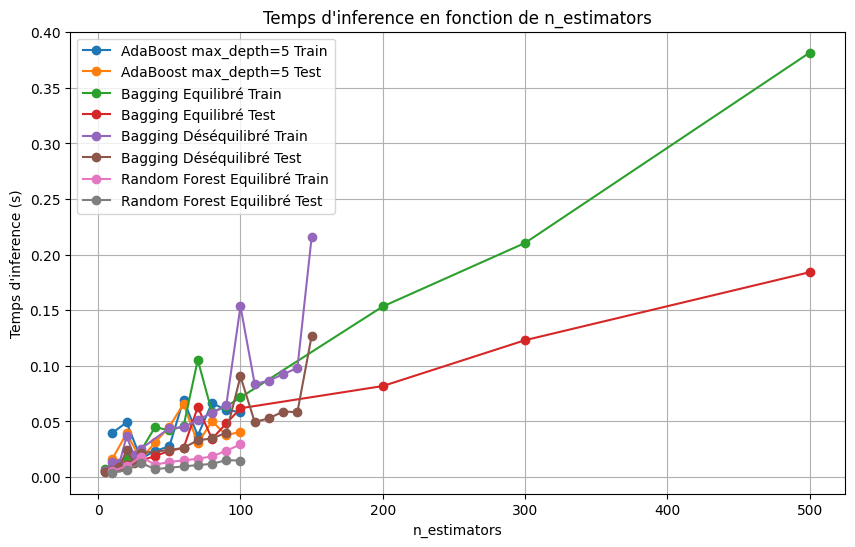

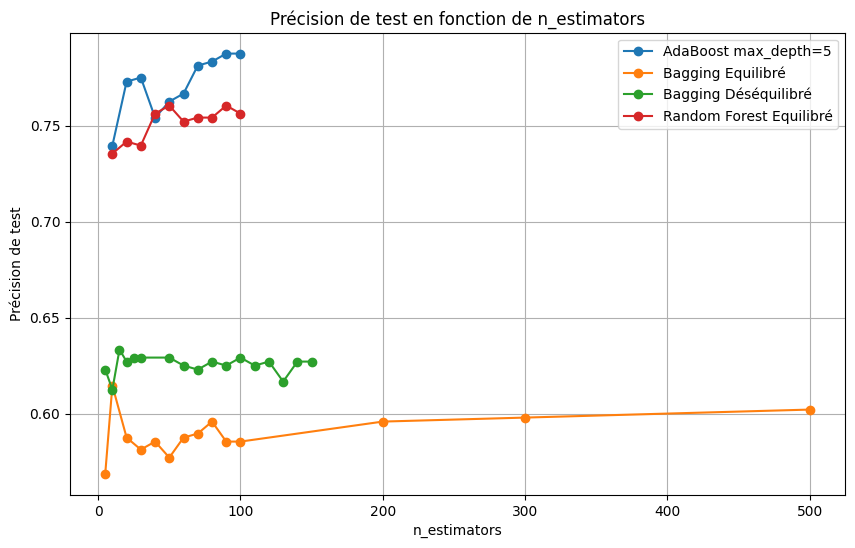

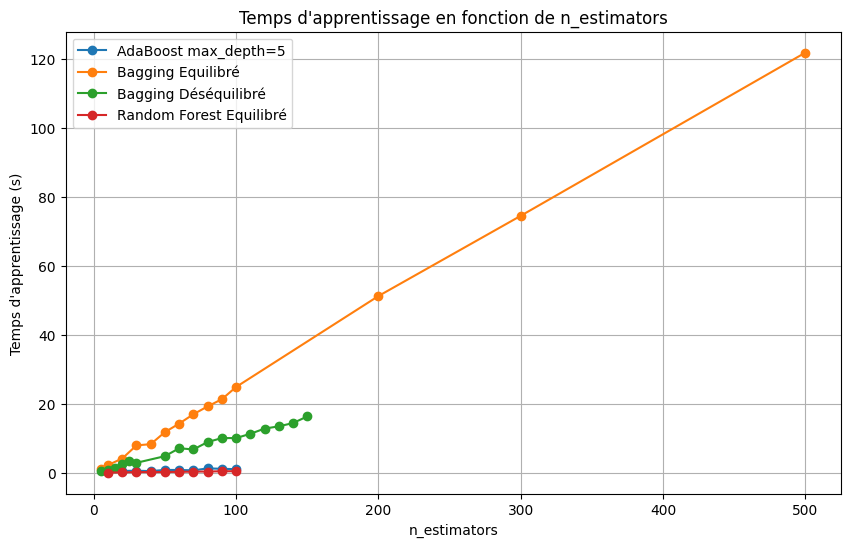

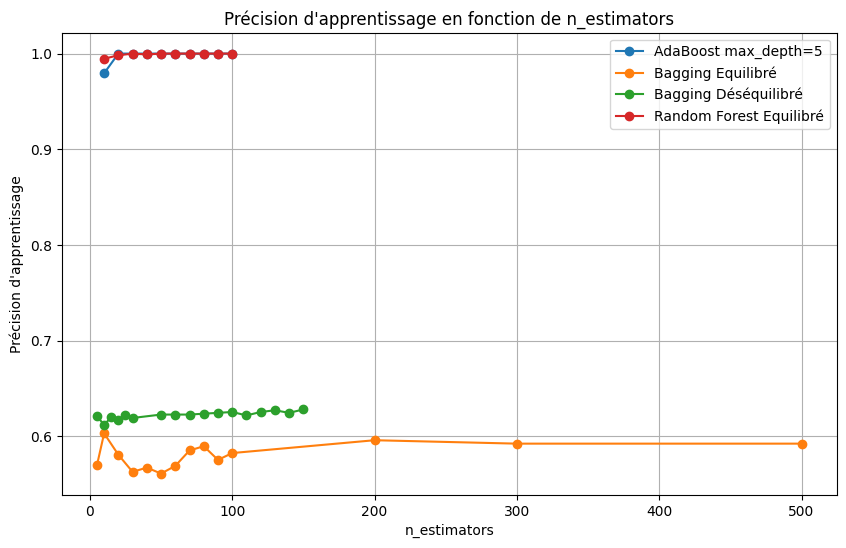

In [ ]:
import matplotlib.pyplot as plt

# Graphique pour les temps d'inference
plt.figure(figsize=(10, 6))
plt.title("Temps d'inference en fonction de n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Temps d'inference (s)")

plt.plot(n_estimators_list, temps_inference_train_list_ada_5, label="AdaBoost max_depth=5 Train", marker='o')
plt.plot(n_estimators_list, temps_inference_test_list_ada_5, label="AdaBoost max_depth=5 Test", marker='o')
plt.plot(n_estimators_list_bagging_equilibre, temps_inference_train_list_bagging_equilibre, label="Bagging Equilibré Train", marker='o')
plt.plot(n_estimators_list_bagging_equilibre, temps_inference_test_list_bagging_equilibre, label="Bagging Equilibré Test", marker='o')
plt.plot(n_estimators_list_desequilibrees, temps_inference_train_list_bagging_desequilibrees, label="Bagging Déséquilibré Train", marker='o')
plt.plot(n_estimators_list_desequilibrees, temps_inference_test_list_bagging_desequilibrees, label="Bagging Déséquilibré Test", marker='o')
plt.plot(n_estimators_list, temps_inference_train_list_rf, label="Random Forest Equilibré Train", marker='o')
plt.plot(n_estimators_list, temps_inference_test_list_rf, label="Random Forest Equilibré Test", marker='o')

plt.legend()
plt.grid(True)
plt.show()

# Graphique pour les accuracies de test
plt.figure(figsize=(10, 6))
plt.title("Précision de test en fonction de n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Précision de test")

plt.plot(n_estimators_list, test_accuracy_list_ada_5, label="AdaBoost max_depth=5", marker='o')
plt.plot(n_estimators_list_bagging_equilibre, test_accuracy_list_bagging_equilibre, label="Bagging Equilibré", marker='o')
plt.plot(n_estimators_list_desequilibrees, test_accuracy_list_bagging_desequilibrees, label="Bagging Déséquilibré", marker='o')
plt.plot(n_estimators_list, test_accuracy_list_rf, label="Random Forest Equilibré", marker='o')

plt.legend()
plt.grid(True)
plt.show()

# Graphique pour les temps d'apprentissage
plt.figure(figsize=(10, 6))
plt.title("Temps d'apprentissage en fonction de n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Temps d'apprentissage (s)")

plt.plot(n_estimators_list, temps_apprentissage_list_ada_5, label="AdaBoost max_depth=5", marker='o')
plt.plot(n_estimators_list_bagging_equilibre, temps_apprentissage_list_bagging_equilibre, label="Bagging Equilibré", marker='o')
plt.plot(n_estimators_list_desequilibrees, temps_apprentissage_list_bagging_desequilibrees, label="Bagging Déséquilibré", marker='o')
plt.plot(n_estimators_list, temps_apprentissage_list_rf, label="Random Forest Equilibré", marker='o')

plt.legend()
plt.grid(True)
plt.show()

# Graphique pour les accuracies d'apprentissage
plt.figure(figsize=(10, 6))
plt.title("Précision d'apprentissage en fonction de n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Précision d'apprentissage")

plt.plot(n_estimators_list, train_accuracy_list_ada_5, label="AdaBoost max_depth=5", marker='o')
plt.plot(n_estimators_list_bagging_equilibre, train_accuracy_list_bagging_equilibre, label="Bagging Equilibré", marker='o')
plt.plot(n_estimators_list_desequilibrees, train_accuracy_list_bagging_desequilibrees, label="Bagging Déséquilibré", marker='o')
plt.plot(n_estimators_list, train_accuracy_list_rf, label="Random Forest Equilibré", marker='o')

plt.legend()
plt.grid(True)
plt.show()


AdaBoost (max_depth=5) offre la meilleure précision sur le test (78%), avec des temps d'apprentissage et d'inférence raisonnables. Random Forest (75-76%) est également performant, tandis que le modèle Bagging (63-64%) montre des performances inférieures, avec des temps plus élevés à mesure que `n_estimators` augmente.

Adaboost, Random Forest et Bagging sont des techniques d'apprentissage automatique ensembliste puissantes qui peuvent améliorer les performances des modèles de base. Adaboost est généralement considérée comme étant plus résistante au surapprentissage que Random Forest et Bagging, mais elle est également plus complexe. Random Forest est une bonne option générale pour la classification et la régression, tandis que Bagging est une bonne option pour réduire la variance des modèles.